# Time Series Kaggle Project Julian Cerro

#### Problem Statement: How can we predict water availability>

In [1]:
import pandas as pd

total_data = pd.read_csv("../data/raw/Aquifer_Auser.csv")
total_data.head()

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
0,05/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.2,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,09/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### I will start with Depth to groundwater since it is an important indicator of water availability, which aligns with the problem of predicting water levels

In [2]:
target_column = "Depth_to_Groundwater_LT2"

missing_values = total_data[target_column].isna().sum()

print(f"Valores faltantes en {target_column}: {missing_values}")

Valores faltantes en Depth_to_Groundwater_LT2: 3352


In [3]:
#Since there are many, I will compare the goundwater columns with others
groundwater_columns = [col for col in total_data.columns if "Depth_to_Groundwater" in col]

missing_values_summary = total_data[groundwater_columns].isna().sum()

print("Missing values in groundwater columns:")
print(missing_values_summary)

Missing values in groundwater columns:
Depth_to_Groundwater_LT2     3352
Depth_to_Groundwater_SAL     3609
Depth_to_Groundwater_PAG     4347
Depth_to_Groundwater_CoS     3839
Depth_to_Groundwater_DIEC    4884
dtype: int64


### Handling Missing values

In [4]:
mean_value = total_data[target_column].mean()
total_data[target_column] = total_data[target_column].fillna(mean_value)

#Verify
missing_after = total_data[target_column].isna().sum()
print(f"Missing values in {target_column} after mean imputation: {missing_after}")


Missing values in Depth_to_Groundwater_LT2 after mean imputation: 0


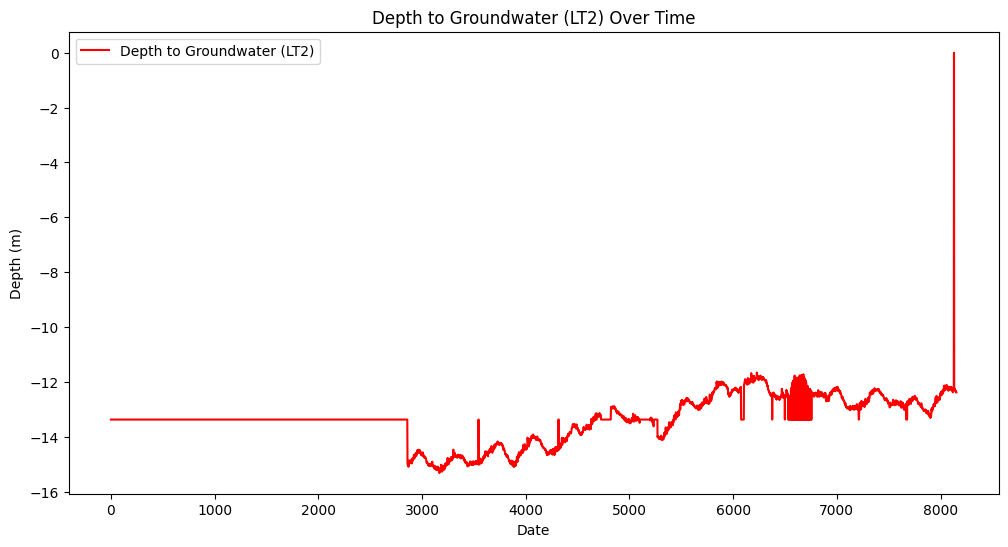

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(total_data[target_column], label="Depth to Groundwater (LT2)", color="red")
plt.title("Depth to Groundwater (LT2) Over Time")
plt.xlabel("Date")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

#### At the beginning there was no variation. The water depth appears to decrease over time, but there is a sudden spike toward the end. (could be an outlier)

#### I will reduce some rows to make smaller the anomally

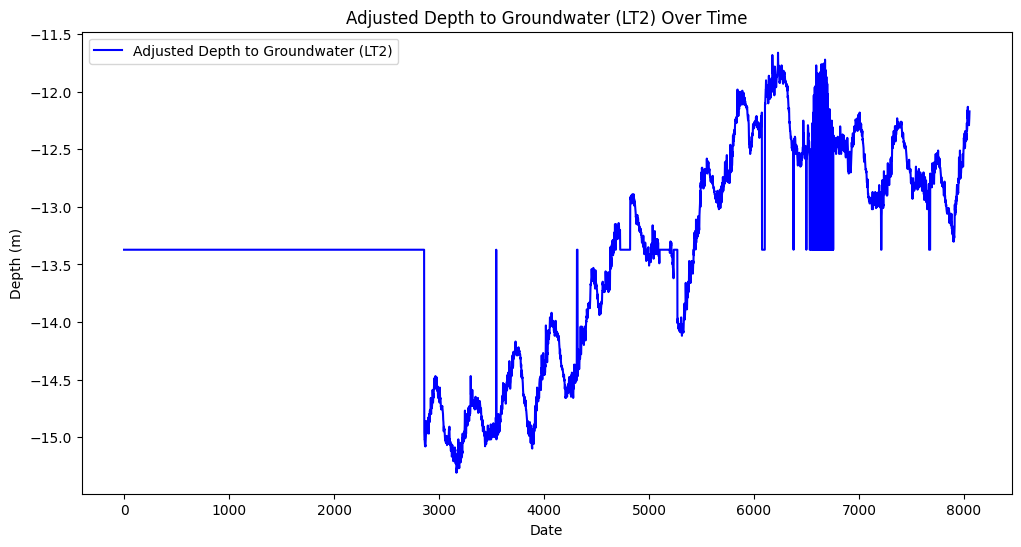

In [6]:
data = total_data.iloc[:-100]

plt.figure(figsize=(12, 6))
plt.plot(data[target_column], label="Adjusted Depth to Groundwater (LT2)", color="blue")
plt.title("Adjusted Depth to Groundwater (LT2) Over Time")
plt.xlabel("Date")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

#### Now we are going to divide data and visualize

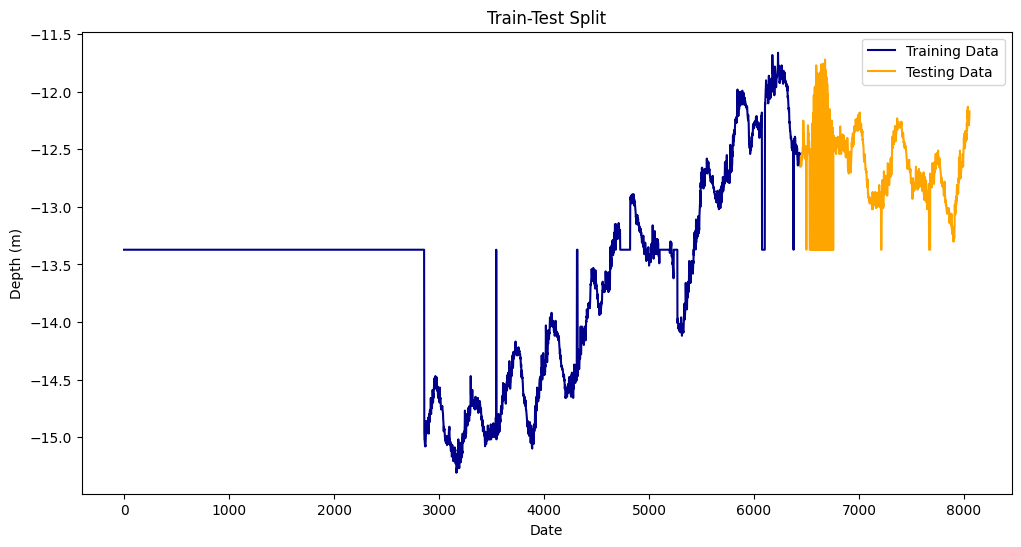

In [7]:
#(80% training, 20% testing)
split_index = int(len(data) * 0.8)

# Split into training and testing
train = data.iloc[:split_index]
test = data.iloc[split_index:]

plt.figure(figsize=(12, 6))
plt.plot(train[target_column], label='Training Data', color='darkblue')
plt.plot(test[target_column], label='Testing Data', color='orange')
plt.title("Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

#### Now we are going to continue with the ARIMA model, 

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

# Test stationarity on the training data
stationarity_results = test_stationarity(train[target_column])
print(stationarity_results)

Dickey-Fuller test results:
Test Statistic                   -1.620413
p-value                           0.472513
#Lags Used                       29.000000
Number of Observations Used    6413.000000
Critical Value (1%)              -3.431370
Critical Value (5%)              -2.861991
Critical Value (10%)             -2.567010
dtype: float64


#### The data is not estacionary, lets convert it

Dickey-Fuller test results:
Test Statistic                -1.666224e+01
p-value                        1.570515e-29
#Lags Used                     2.800000e+01
Number of Observations Used    6.413000e+03
Critical Value (1%)           -3.431370e+00
Critical Value (5%)           -2.861991e+00
Critical Value (10%)          -2.567010e+00
dtype: float64


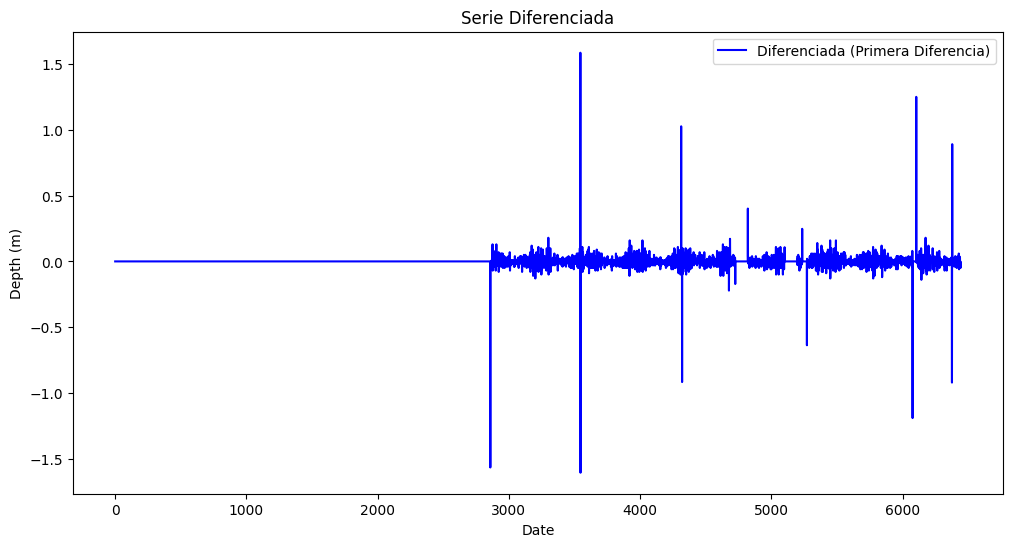

In [9]:
#Convert dataset into estationary
train_diff = train[target_column].diff().dropna()

stationarity_results_diff = test_stationarity(train_diff)
print(stationarity_results_diff)

plt.figure(figsize=(12, 6))
plt.plot(train_diff, label="Diferenciada (Primera Diferencia)", color="blue")
plt.title("Serie Diferenciada")
plt.xlabel("Date")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

#### It is still not stationary, I will do a second diff.

Dickey-Fuller test results:


Test Statistic                  -23.220211
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6406.000000
Critical Value (1%)              -3.431371
Critical Value (5%)              -2.861991
Critical Value (10%)             -2.567010
dtype: float64


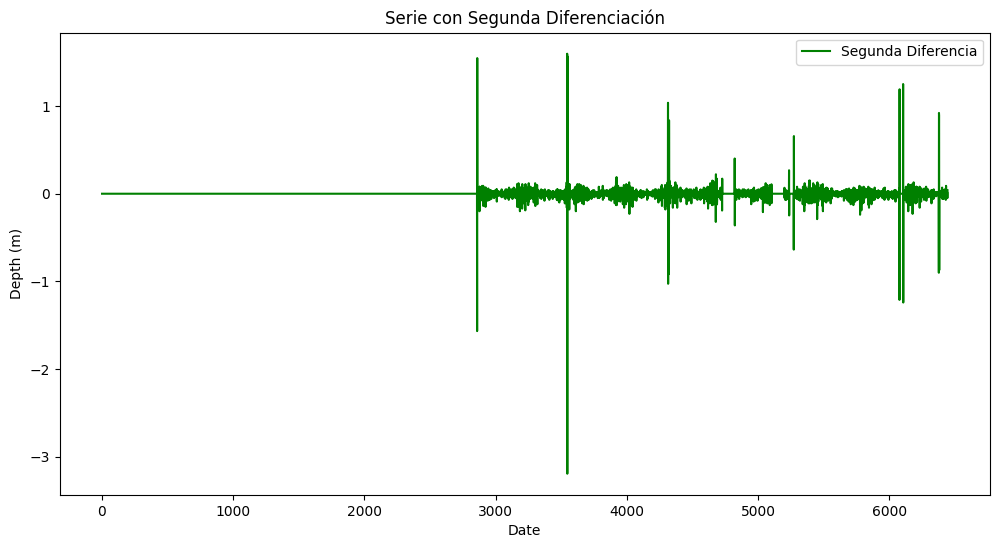

In [ ]:
train_diff_2 = train_diff.diff().dropna()

stationarity_results_diff_2 = test_stationarity(train_diff_2)
print(stationarity_results_diff_2)

plt.figure(figsize=(12, 6))
plt.plot(train_diff_2, label="Segunda Diferencia", color="green")
plt.title("Serie con Segunda Diferenciación")
plt.xlabel("Date")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

### Construct ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train[target_column], order=(1, 2, 1))  # p=1, d=2, q=1
model_fit = model.fit()

print(model_fit.summary())

                                  SARIMAX Results                                   
Dep. Variable:     Depth_to_Groundwater_LT2   No. Observations:                 6443
Model:                       ARIMA(1, 2, 1)   Log Likelihood                9720.700
Date:                      Mon, 25 Nov 2024   AIC                         -19435.400
Time:                              14:53:28   BIC                         -19415.089
Sample:                                   0   HQIC                        -19428.372
                                     - 6443                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0939      0.001    -70.770      0.000      -0.097      -0.091
ma.L1         -1.0000      0.059    -16.896      0.000      -1.116      -0.884
sigm

#### Predict test

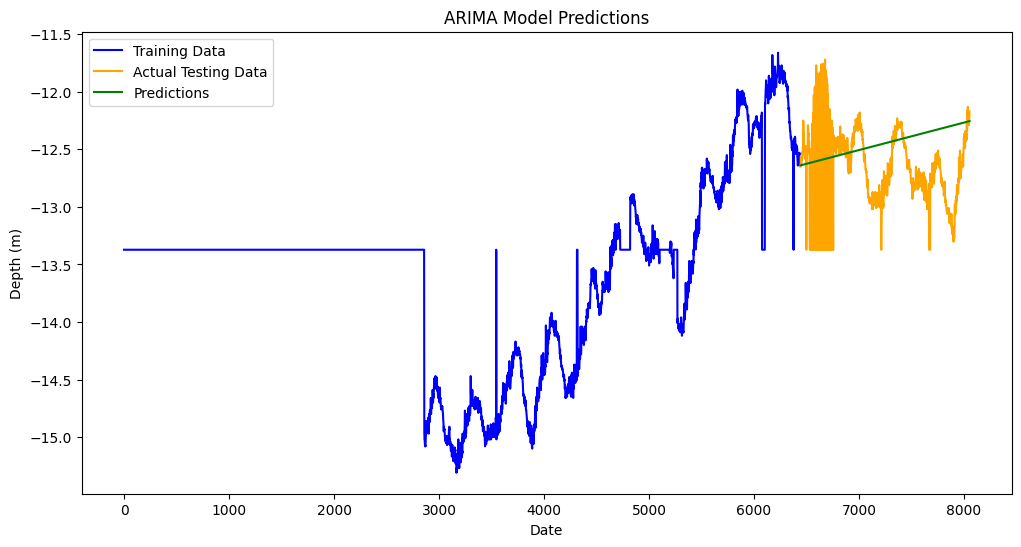

In [ ]:
forecast = model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(train[target_column], label='Training Data', color='blue')
plt.plot(test[target_column], label='Actual Testing Data', color='orange')
plt.plot(test.index, forecast, label='Predictions', color='green')
plt.title("ARIMA Model Predictions")
plt.xlabel("Date")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

#### Evaluate model:

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test[target_column], forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.46433396658916065


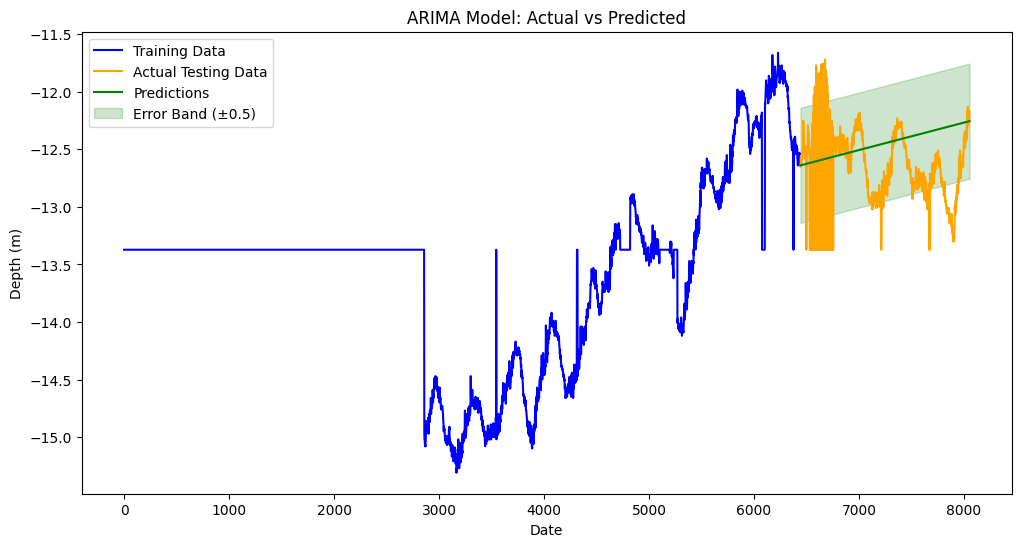

Final Root Mean Squared Error (RMSE): 0.46433396658916065


In [15]:
# Visualización limpia de resultados
plt.figure(figsize=(12, 6))
plt.plot(train[target_column], label='Training Data', color='blue')
plt.plot(test[target_column], label='Actual Testing Data', color='orange')
plt.plot(test.index, forecast, label='Predictions', color='green')
plt.fill_between(test.index, forecast - 0.5, forecast + 0.5, color='green', alpha=0.2, label="Error Band (±0.5)")
plt.title("ARIMA Model: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Depth (m)")
plt.legend()
plt.show()

# Mostrar el RMSE final
print(f"Final Root Mean Squared Error (RMSE): {rmse}")

#### The ARIMA(1, 2, 1) model was used to predict groundwater depth (Depth_to_Groundwater_LT2). It achieved an RMSE of 0.4643, meaning the model's predictions are fairly accurate but don’t fully capture the ups and downs in the real data. The green line shows the predictions, which follow the general trend, and the light green band shows the possible margin of error (±0.5).

#### Overall, this model works well for a simple approach, but it could be improved by trying the parameters or more advanced methods like SARIMA to better handle the complexity of the data. Still, the results are solid for a straightforward and practical solution.